# **Type III Solar Radio Burst Analysis Tutorial**

**Overview:** In three parts we’ll cover  

1. Introduction to NenuFAR & Type III bursts  
2. Automated and manual burst detection  
3. Detailed burst analysis: drift rates, density models, rise/decay fitting 

---

**Developed by:** Jinge ZHANG, Paris Observatory (Meudon Site)

**My e-mail::** Jinge.Zhang@obspm.fr


## **Part 0: Before we start:**

### **0.1 Setting Up the Environment**
Before running this notebook, ensure running **Python 3.12 kernel**, and the required dependencies are installed:

The list below isn’t exhaustive—install any additional dependencies as they’re reported missing.

```bash
#  Create & activate a Python 3.12 venv.
python3.12 -m venv my_pyenv

# Activate the Python environment you just created.
source my_pyenv/bin/activate


# Install essential Python packages
pip install numpy
pip install matplotlib
pip install astropy[recommended] --upgrade
pip install scipy --upgrade
pip install --upgrade https://github.com/AlanLoh/nenupy/tarball/master

### **0.2 Matplotlib Inline Mode**

To display plots directly in the notebook, we use the following magic command:

In [1]:
%matplotlib inline

### **0.3 Import Required Libraries and Tools**

This cell imports essential tools for handling and analyzing spectral data.

In [2]:
pip install --upgrade https://github.com/AlanLoh/nenupy/tarball/master

     \ 80.3 MB 3.4 MB/s 0:00:390mm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pyproj-3.6.1-cp39-cp39-macosx_11_0_arm64.whl.metadata (31 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 2.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached pyproj-3.6.1-cp39-cp39-macosx_11_0_arm64.whl (4.9 MB)
  Created wheel for nenupy: filename=nenupy-2.8.6-py3-none-any.whl size=4078338 sha256=0b3aba21a5a76aefca3db675c25eb9af29b2a8ad013c8d92051d747b7fc95750
  Stored in directory: /private/var/folders/h0/fwyd1b_d61g7s42h2zvyjqc80000gp/T/pip-ephem-wheel-cache-52knlzr3/wheels/56/53/5e/d0dc79ec1653bc78fc174f15f4f3f49043d1cabfadc5ca5a3b
  Created wheel for healpy: filename=healpy-1.17.3-cp39-cp39-macosx_11_0_arm64.whl size=1496427 sha256=b6b8b31964362c39ac20e81da4e4c7

In [3]:
import os
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, num2date, date2num
import numpy as np
from datetime import datetime
import astropy.units as u


# These are the tools that developed for analysing type III bursts.

from nenutools.combine_spectra  import combine_spectra, load_combined_hdf5
from nenutools.detection       import T3_detection
from nenutools.loader          import load_spectra_and_bursts
from nenutools.analysis        import analyze_burst_velocity
from nenutools.window_detection import detect_window

## **Part 1: NenuFAR & Dynamic Spectra**

### What is NenuFAR?
- **NenuFAR** = [New Extension in Nançay Upgrading LOFAR](https://nenufar.obs-nancay.fr/en/homepage-en/#en-presentation)  
- Low-frequency array (10–85 MHz) with superb sensitivity  

### Quick-look Dynamic Spectrum
- Visit the [NENU-SUN quick-look page](https://nenusun.obspm.fr/catalogue/calendar/)  
- Check the availability of NenuFAR solar data in the calendar  
- Examine different types of solar radio bursts—especially Type III bursts  
- Stokes I, Q, U, V quick-looks available  
- **CONTEXT** view includes data from other instruments when available  

### Data Products on the Nançay Server (`nenufar-tf`)
- Raw dynamic spectra delivered as `.spectra` files  
- High time- and frequency-resolution  
- Use the **nenupy** Python package to load and read `.spectra` files  

### **What are the hdf5 data files in our current working space dictionary? Why?**

## **1.1: Load Dynamic Spectra**

In this step we’ll load the three HDF5 files we’ve pre-downloaded:

- **Low-band spectrum** (`_0.hdf5`),  
- **High-band spectrum** (`_1.hdf5`),  
- **Combined spectrum** (`_COM.hdf5`).

We’ll use the `load_combined_hdf5()` function from **combine_spectra.py** to read each file. This will give us:

- `data3d_*`  : 3D array of Stokes-I ([ntime, nchan, 1])  
- `time_jd_*` : array of Julian Dates  
- `time_unix_*`: array of UNIX timestamps (seconds)  
- `time_dt_*` : list of Python `datetime` objects (UTC)  
- `time_mpl_*`: array of Matplotlib datenums (for plotting)  
- `freq_*`    : array of frequency channels (MHz)  


In [17]:
# load the file we already have in our working space

#This is the file path of the 20250329_I_COM.hdf5.
h5path0 = "lab_results/20250329_I_0.hdf5"
h5path1 = "lab_results/20250329_I_1.hdf5"
h5pathCOM = "lab_results/20250329_I_COM.hdf5"

#Using the load_combined_hdf5() in combine_spectra.py to read the file.
data3d_0, time_jd_0, time_unix_0, time_dt_0, time_mpl_0, freq_0 = load_combined_hdf5(h5path0)
data3d_1, time_jd_1, time_unix_1, time_dt_1, time_mpl_1, freq_1 = load_combined_hdf5(h5path1)
data3d, time_jd, time_unix, time_dt, time_mpl, freq = load_combined_hdf5(h5pathCOM)

Loaded HDF5: lab_results/20250329_I_0.hdf5
  data shape : (3528, 125, 1)  (ntime, nchan, 1)
  freq range : 21.73 → 58.81 MHz
  time range : 2025-03-29 12:28:48.131926 → 2025-03-29 12:46:03.663626
Loaded HDF5: lab_results/20250329_I_1.hdf5
  data shape : (3528, 83, 1)  (ntime, nchan, 1)
  freq range : 59.23 → 83.75 MHz
  time range : 2025-03-29 12:28:48.131926 → 2025-03-29 12:46:03.663626
Loaded HDF5: lab_results/20250329_I_COM.hdf5
  data shape : (3528, 208, 1)  (ntime, nchan, 1)
  freq range : 21.73 → 83.75 MHz
  time range : 2025-03-29 12:28:48.131926 → 2025-03-29 12:46:03.663626


### Preparing the Dynamic Spectrum for Plotting
- Remove the singleton polarization axis (shape `(ntime, nchan, 1)` → `(ntime, nchan)`)  
- Transpose to shape `(nchan, ntime)` so that rows correspond to frequency channels and columns to time  

In [18]:
# squeeze off the singleton polarization axis and transpose to (freq × time)
# Simply, reshape data from 3d to 2d. (freq, time, 1) to (freq, time)
spec2d = data3d.squeeze().T
spec2d_0 = data3d_0.squeeze().T
spec2d_1 = data3d_1.squeeze().T


## **1.2: Visualizing the HIGH and LOW Bands Separately**
- Create a 2-row figure sharing the time axis  
- Top panel: HIGH band dynamic spectrum (`spec2d_1`)  
- Bottom panel: LOW band dynamic spectrum (`spec2d_0`)  
- Colorbars show Stokes I amplitude, and time formatted as UTC 

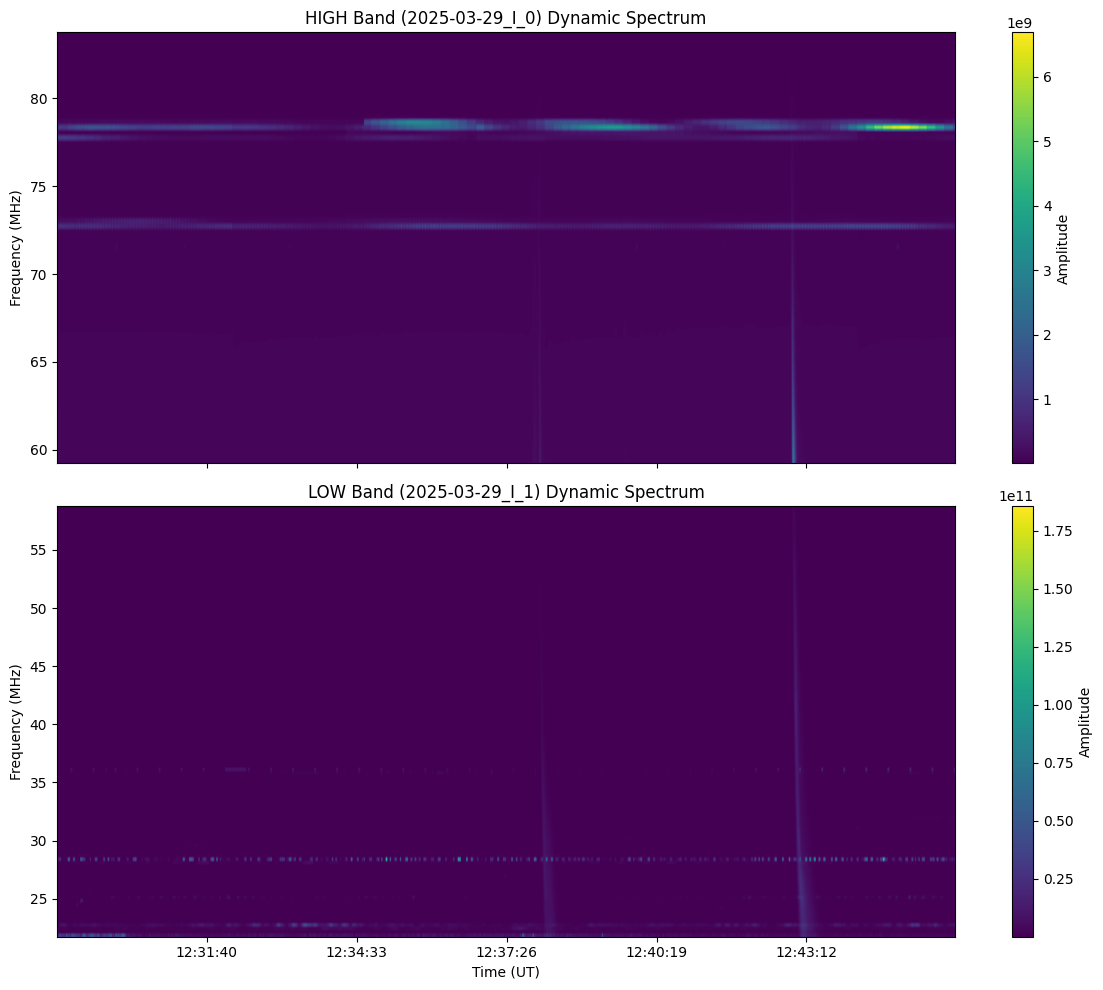

In [19]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot low band
im0 = ax0.imshow(
    spec2d_1,
    aspect="auto", origin="lower",
    extent=[time_mpl_1[0], time_mpl_1[-1], freq_1[0], freq_1[-1]],
    cmap="viridis"
)
ax0.set_ylabel("Frequency (MHz)")
ax0.set_title("HIGH Band (2025-03-29_I_0) Dynamic Spectrum")
ax0.xaxis.set_major_formatter(DateFormatter("%H:%M:%S"))
plt.colorbar(im0, ax=ax0, label="Amplitude")

# Plot high band
im1 = ax1.imshow(
    spec2d_0,
    aspect="auto", origin="lower",
    extent=[time_mpl_0[0], time_mpl_0[-1], freq_0[0], freq_0[-1]],
    cmap="viridis"
)
ax1.set_ylabel("Frequency (MHz)")
ax1.set_title("LOW Band (2025-03-29_I_1) Dynamic Spectrum")
ax1.xaxis.set_major_formatter(DateFormatter("%H:%M:%S"))
plt.colorbar(im1, ax=ax1, label="Amplitude")

ax1.set_xlabel("Time (UT)")
plt.tight_layout()
plt.show()

## **1.3: Plot Full Dynamic Spectrum with Optional Zoom**
- **Inputs** (from previous cells):
  - `spec2d`   : 2D array `(nfreq, ntime)`  
  - `time_mpl` : 1D array `ntime` (Matplotlib datenums)  
  - `freq`     : 1D array `nfreq` (MHz)  
- Toggle zoom with `do_zoom=True` and set your time/frequency limits  
- When zooming, color limits are recomputed over the sub‐window  

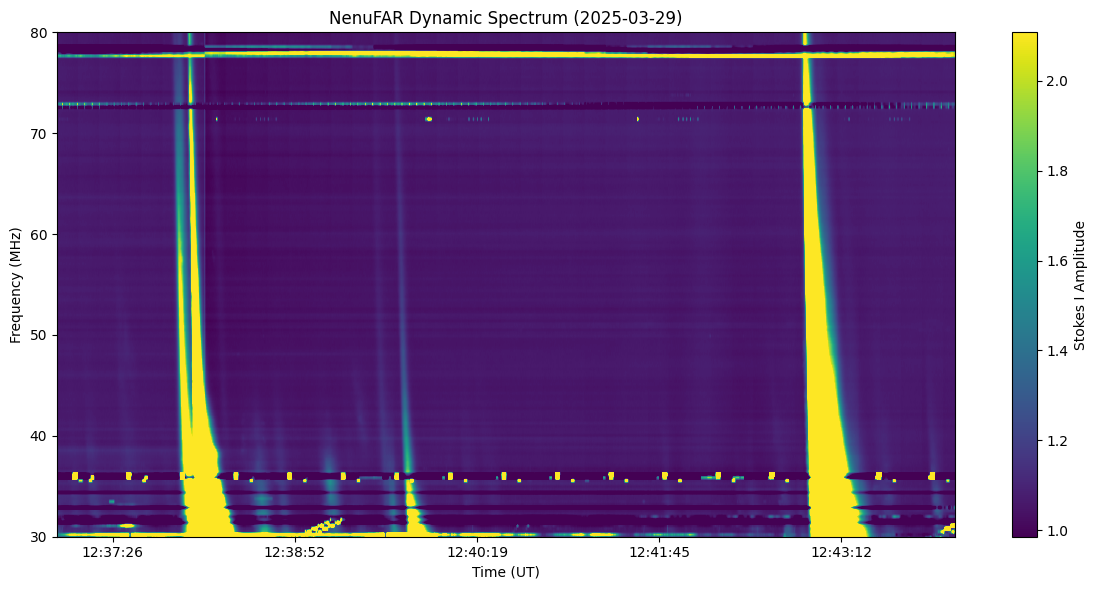

In [20]:
# assume you already have:
#   spec2d    : 2D array of shape (nfreq, ntime)
#   time_mpl  : 1D array of length ntime (Matplotlib datenums)
#   freq      : 1D array of length nfreq (MHz)

# -- Optional zoom window (uncomment or set do_zoom=True) --
do_zoom = True

# define your zoom limits here:
t0 = datetime.strptime("2025-03-29 12:37:00", "%Y-%m-%d %H:%M:%S")
t1 = datetime.strptime("2025-03-29 12:44:06", "%Y-%m-%d %H:%M:%S")
t_start = date2num(t0);  t_end = date2num(t1)
f_min, f_max = 30.0, 80.0  # MHz

# -------------------------------------------------------

fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(
    spec2d,
    aspect='auto',
    origin='lower',
    extent=[time_mpl[0], time_mpl[-1], freq[0], freq[-1]],
    cmap='viridis'
)
cbar = plt.colorbar(im, ax=ax, label='Stokes I Amplitude')

# Format axes
ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title('NenuFAR Dynamic Spectrum (2025-03-29)')

if do_zoom:
    # apply zoom limits
    ax.set_xlim(t_start, t_end)
    ax.set_ylim(f_min, f_max)
    # recompute color‐limits on zoomed region
    time_idx = np.where((time_mpl >= t_start) & (time_mpl <= t_end))[0]
    freq_idx = np.where((freq    >= f_min ) & (freq    <= f_max))[0]
    sub_spec = spec2d[np.ix_(freq_idx, time_idx)]
    vmin, vmax = np.nanpercentile(sub_spec, [5, 95])
    im.set_clim(vmin, vmax)
    cbar.mappable.set_clim(vmin, vmax)

plt.tight_layout()
plt.show()

## **Part 2: Locate Type III Bursts & Data Pre-Processing**

Before we can measure drift rates and velocities, we first need to pinpoint where the Type III bursts occur in our dynamic spectrum. 
This means defining a **region of interest (ROI)** in time and frequency that contains the burst, then extracting that sub-spectrum for further analysis.

> **Questions to consider**  
> - What criteria determine a burst’s start and end times?  
> - How do you choose an appropriate frequency band for the burst?  
> - What kinds of noise or RFI appear in the spectrum, and how might they bias your drift-rate measurement?  
> - Why and how do we normalize the signal before peak finding?

In this section we will:
1. **Manually select** a time–frequency window and run `detect_window()` to extract and plot the burst sub-spectrum.  
2. **Automatically scan** the full dynamic spectrum with `T3_detection()` to detect all Type III bursts, clean RFI, and save per-chunk diagnostics.  
3. **Assemble** the burst metadata (start/end times, frequency range, peak times) so it’s ready for our velocity analysis in Part 3.  

## **2.1: Now choose a time–frequency window containing the burst you’d like to analyze:**

1. **Pick start/end times** (UTC) by looking at the spectrum plot.
2. **Choose** a frequency band (`f_min`, `f_max` in MHz) encompassing the burst.
3. **Run** the detection routine to find the peak times/frequencies and plot the window.

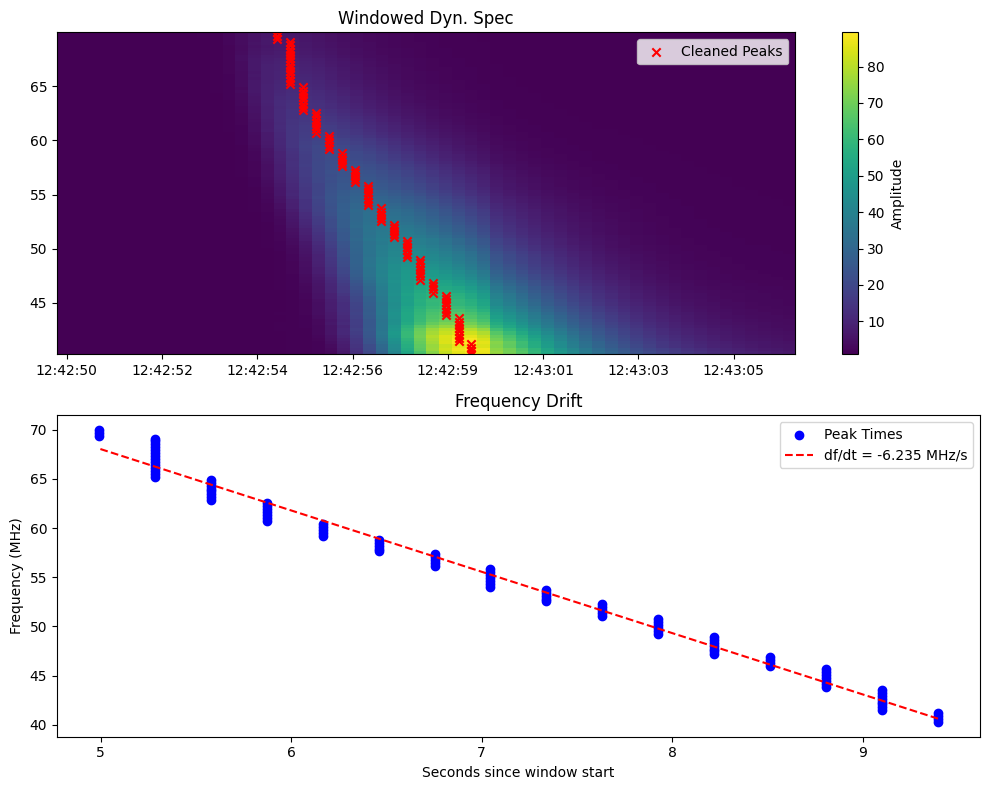

In [21]:

t0 = datetime(2025, 3, 29, 12, 42, 50)  # start time
t1 = datetime(2025, 3, 29, 12, 43, 7)  # end time

# convert to Matplotlib float‐dates (days)
t_start = date2num(t0)
t_end   = date2num(t1)

# 3) pick your freq window (MHz)
f_min, f_max = 40, 70

# 4) run the detection + plotting
results = detect_window(
    data3d,           # (ntime, nfreq, 1) array from load_combined_hdf5
    time_mpl,         # Matplotlib datenums
    freq,             # MHz axis
    t_start,          # mpl date start
    t_end,            # mpl date end
    f_min,            # MHz low‐end
    f_max             # MHz high‐end
)


## **2.2: Compute Electron Beam Velocity**

With your window detected, call the **`analyze_burst_velocity`** routine to:

1. **Fit** the burst in each frequency channel (FWHM or 1/e).  
2. **Extract** peak, start & end times × frequencies.  
3. **Convert** the frequency drift to radial distance using your chosen density model and emission mechanism.  
4. **Plot**:
   - Windowed dynamic spectrum with peak markers  
   - Frequency drift & linear fit  
   - Radial distance vs time (beam velocities)  
   - (Optional) Density‐vs‐radius comparison  

**Parameters**  
- `density_model`: coronal density profile (`"saito"`, `"leblanc98"`, `"parkerfit"`, …)  
- `emission_mechanism`: `"F"` for fundamental, `"H"` for harmonic emission  
- `fit_method`: define start/end (`"FWHM"` or `"1/e"`)  
- `y_scale`: plot axis scaling (`"frequency"`, `"inverse"`, or `"log"`)  
- `fit_mode`: fitting algorithm (`"none"`, `"single"`, or `"split"`)  
- `show_density_models`: toggle extra figure comparing all density models  


🔹 Processing Burst 1...
   Time Range: 2025-03-29 12:42:50+00:00 to 2025-03-29 12:43:07+00:00
   Frequency Range: 70.00 MHz to 40.00 MHz
   Extracted Data Shape: (58, 100)
   Drift Rate (df/dt): -6.2345 MHz/s
   Electron Beam Velocity (Peak): 0.1986 c
   Electron Beam Velocity (Start): 0.2389 c
   Electron Beam Velocity (End): 0.1737 c


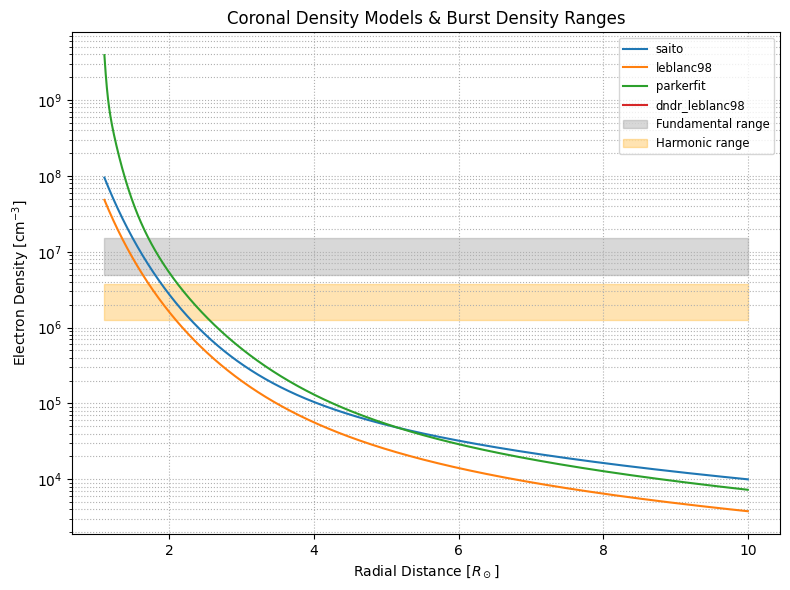

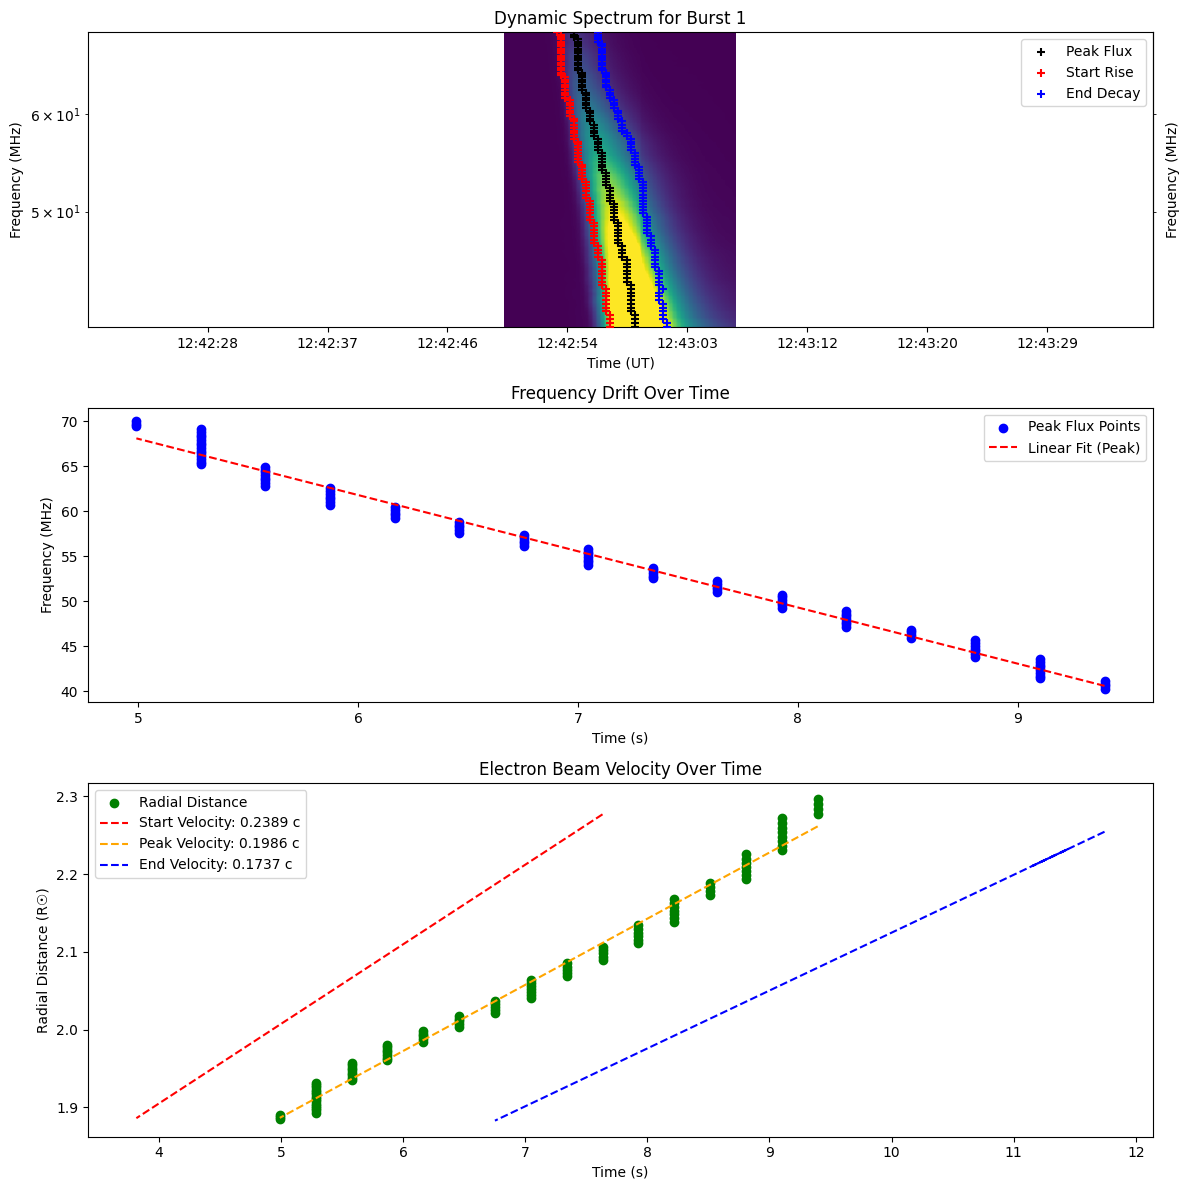

In [22]:

analyze_burst_velocity(
    results,
    density_model="saito", # chose a density model
    emission_mechanism="H",# "F"=fundamental, "H"=second harmonic
    fit_method="FWHM",
    y_scale="log",
    fit_mode="none",
    debug=False,
    show_density_models=True
)

## **2.3: Automated Type III Burst Detection**

Manually picking a time–frequency Region of Interest (ROI) can be tedious when multiple Type III bursts occur.  
To detect all bursts over your entire observation at once, use the **`T3_detection`** routine on the full dynamic spectrum. It will:

1. **Split** the time series into overlapping chunks  
2. **Mask** RFI-polluted frequency channels  
3. **Detect** burst peaks in both raw and smoothed total-power series  
4. **Save** per-chunk diagnostic plots and burst lists (pickles)



Loaded HDF5: lab_results/20250329_I_COM.hdf5
  data shape : (3528, 208, 1)  (ntime, nchan, 1)
  freq range : 21.73 → 83.75 MHz
  time range : 2025-03-29 12:28:48.131926 → 2025-03-29 12:46:03.663626


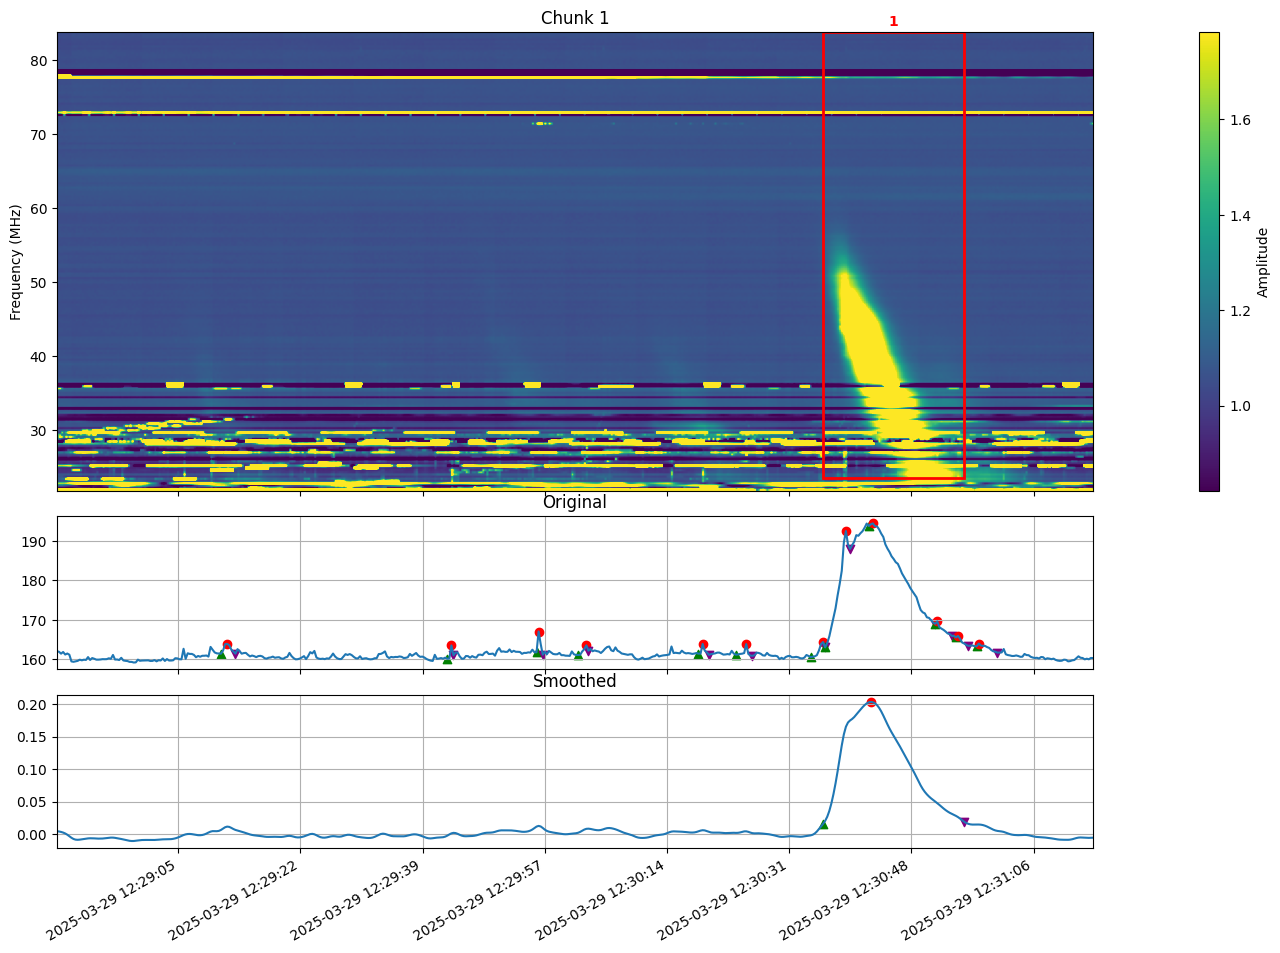

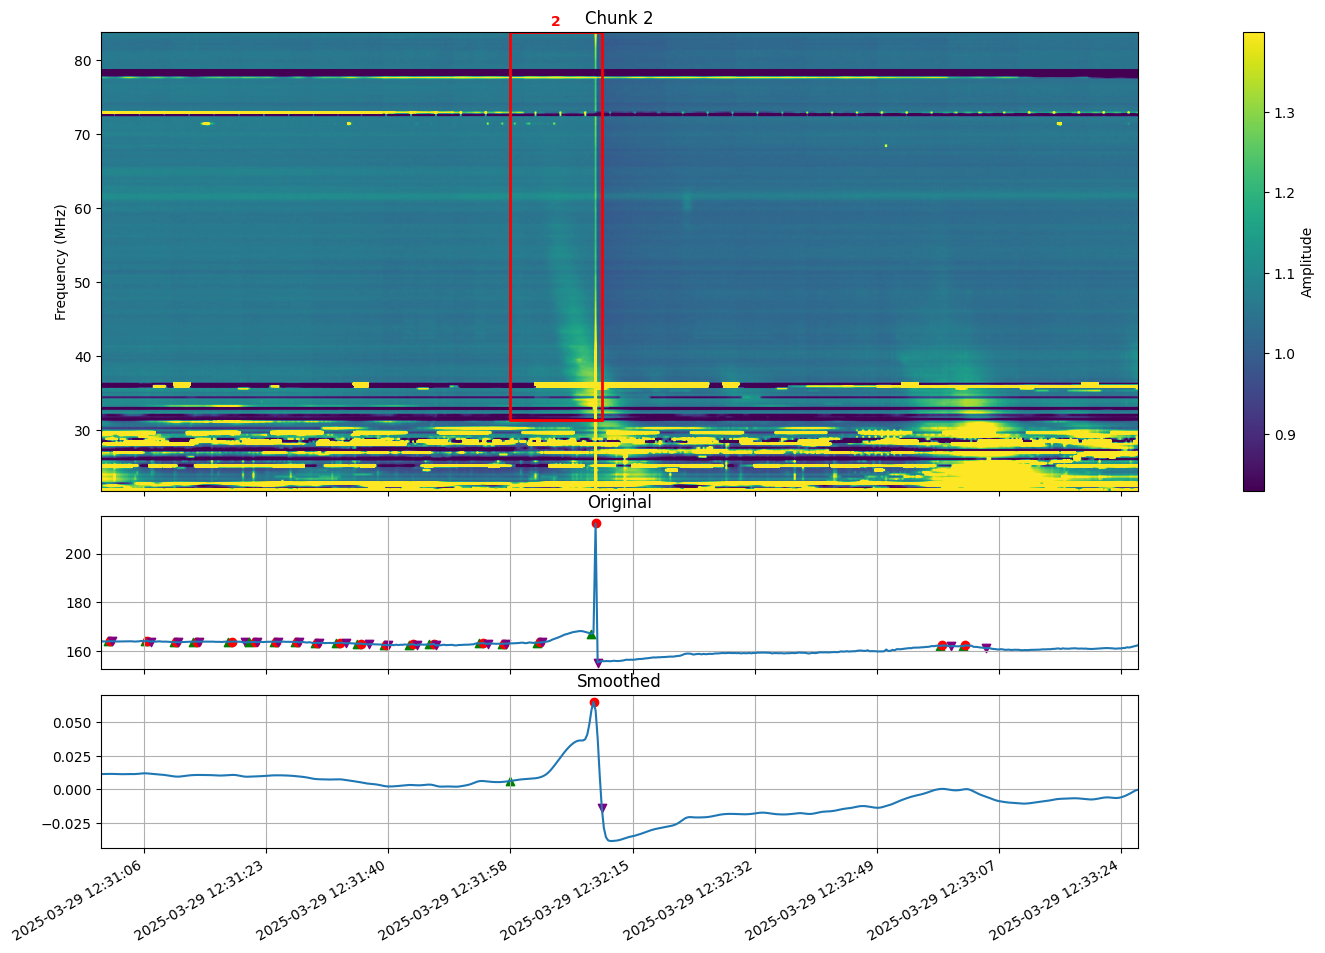

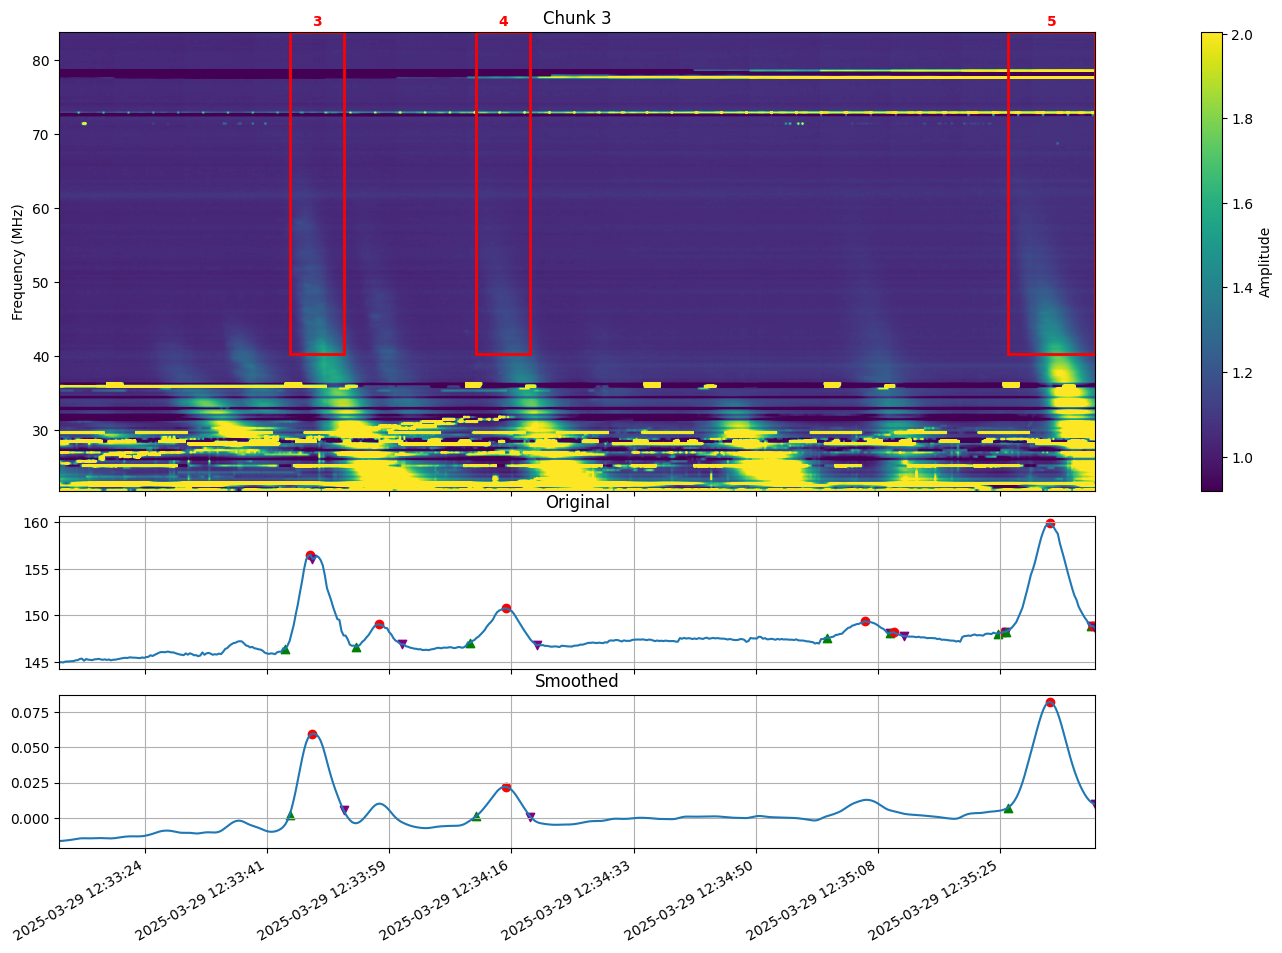

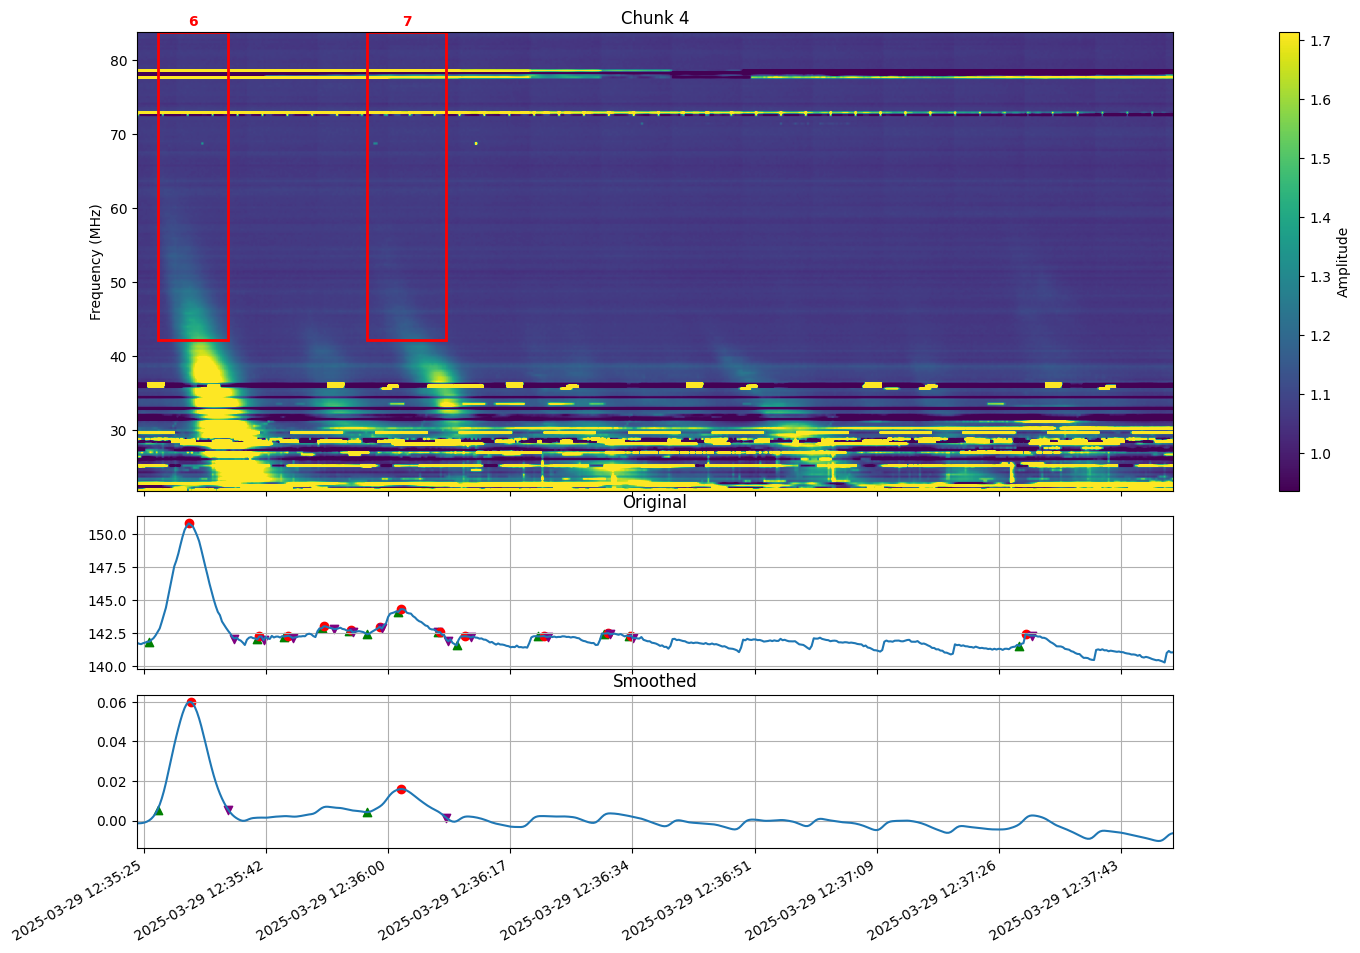

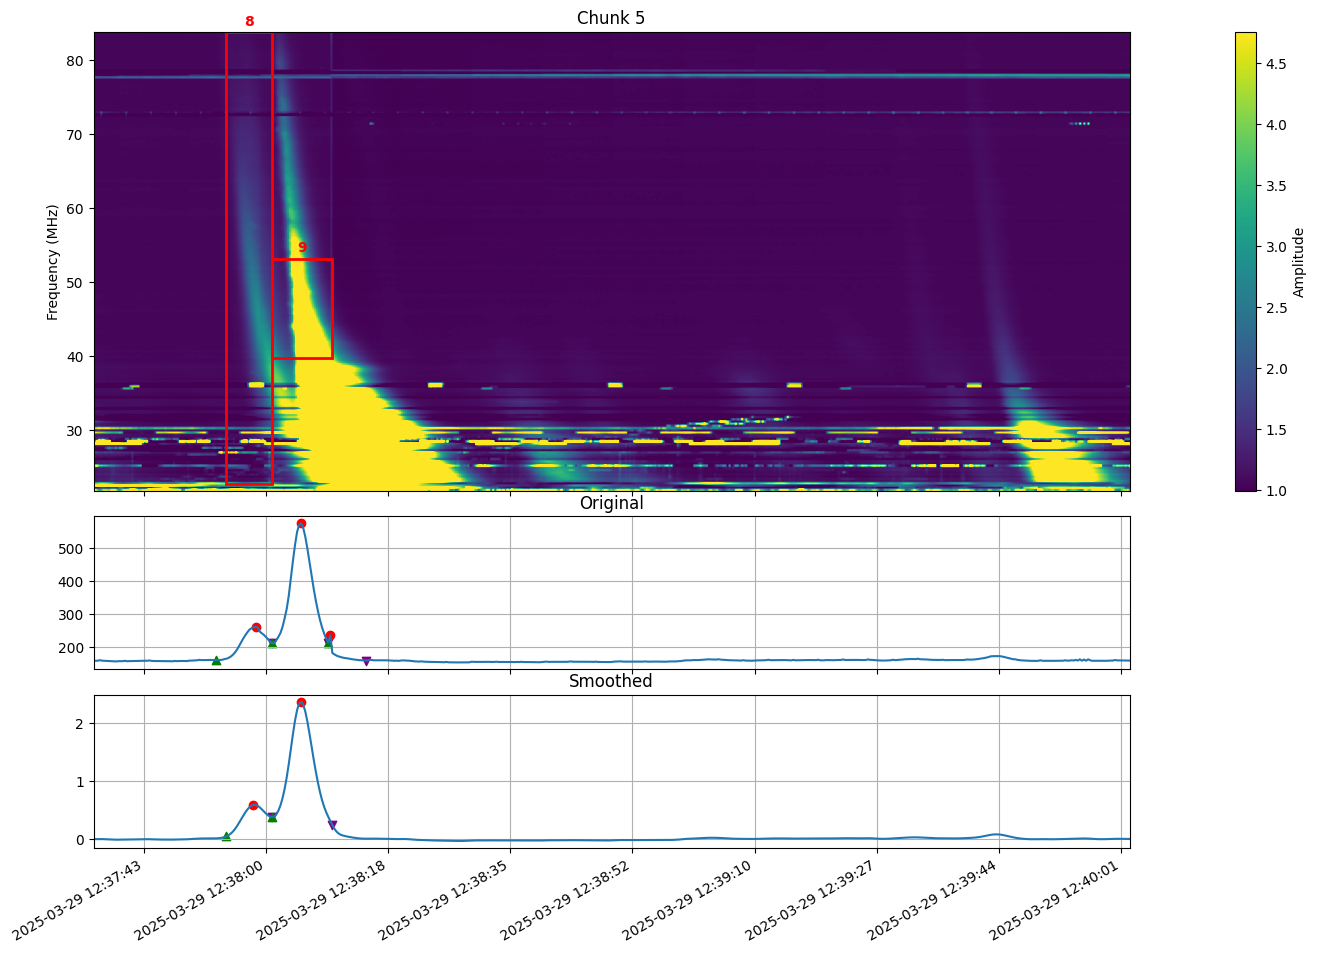

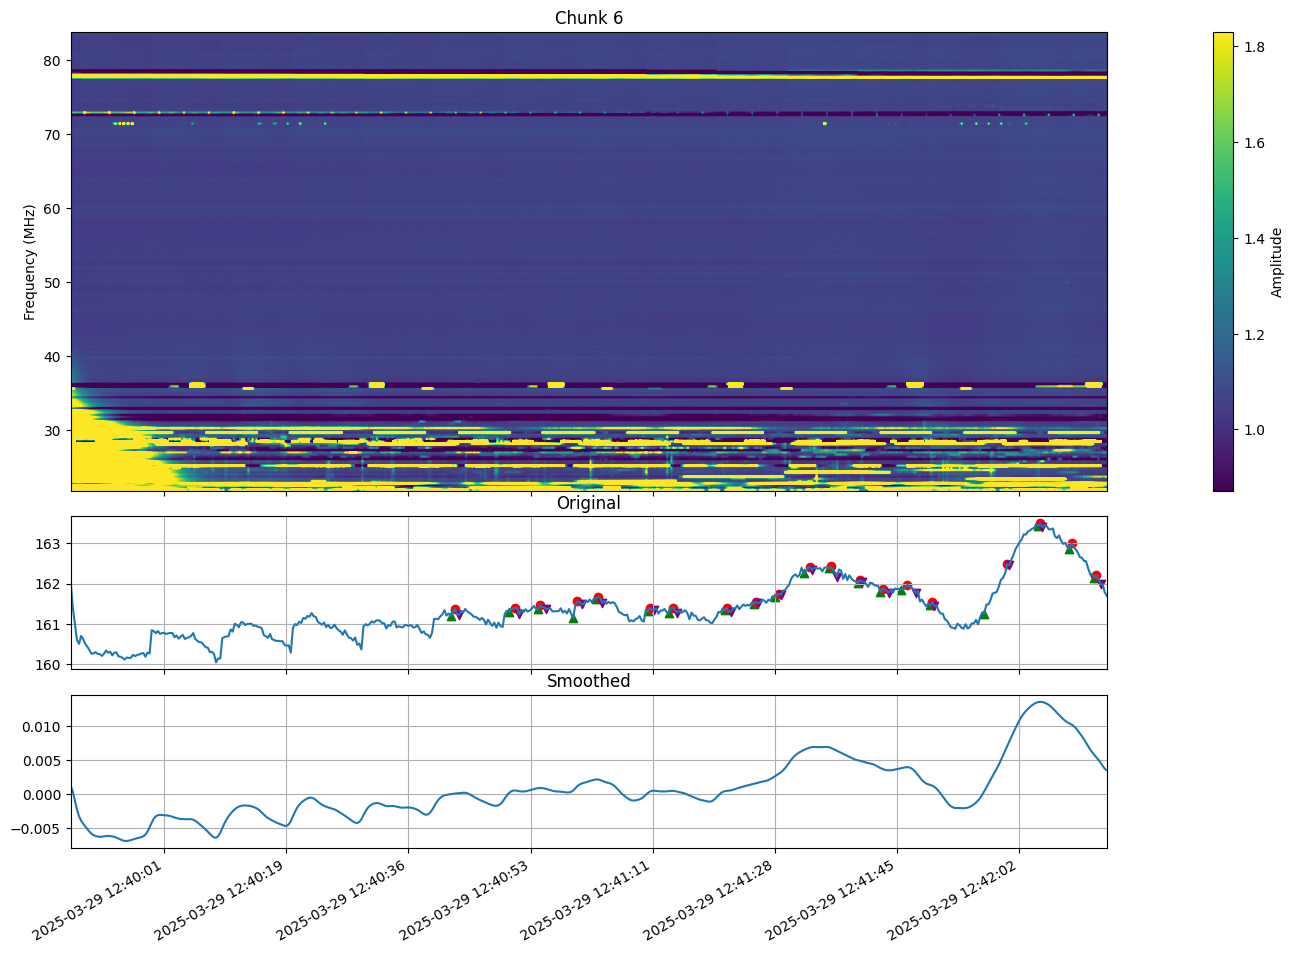

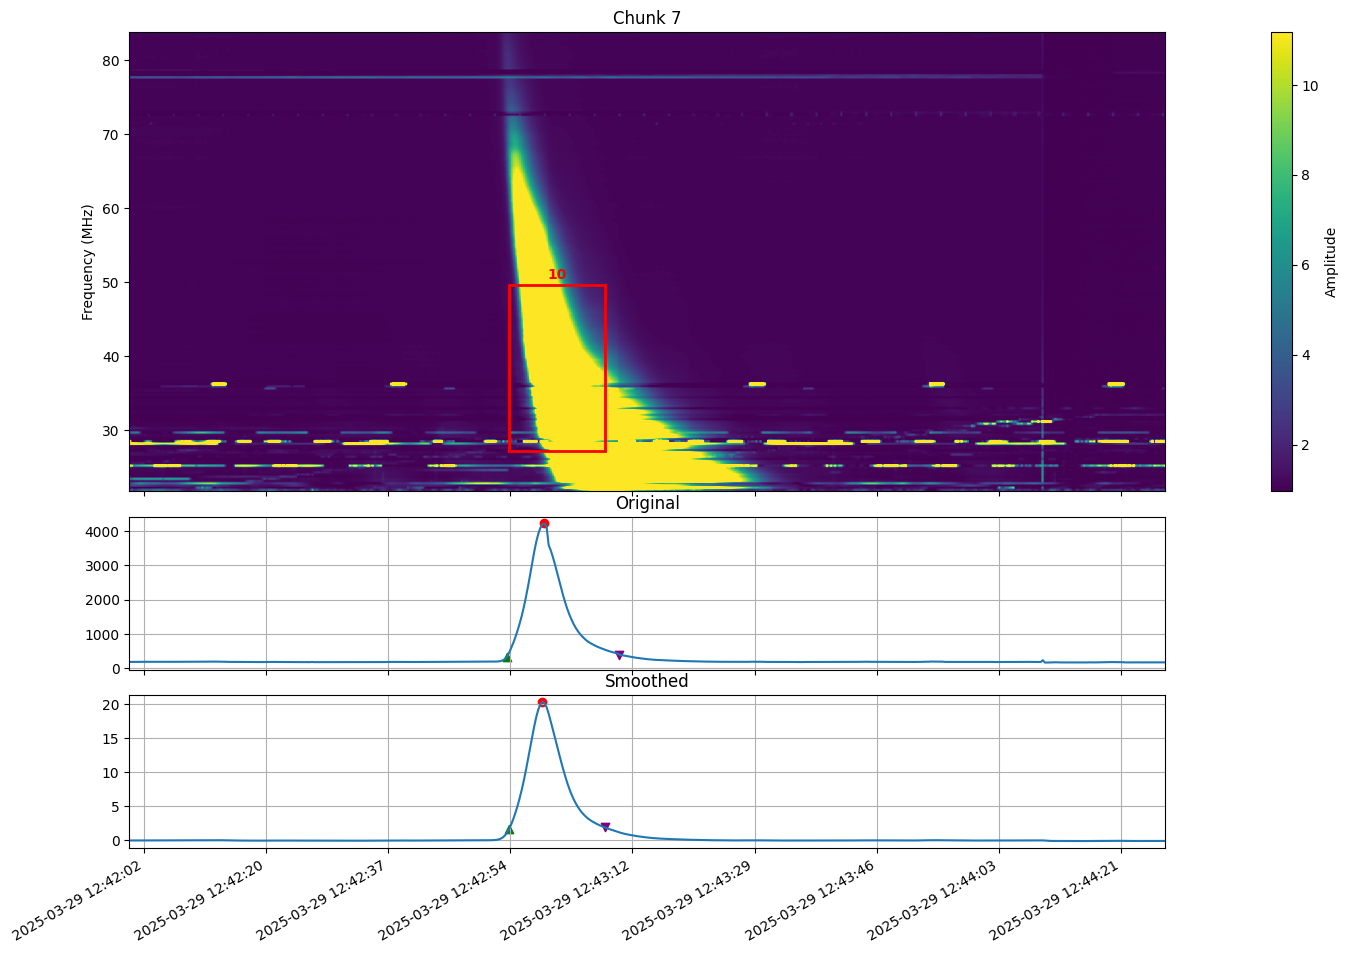

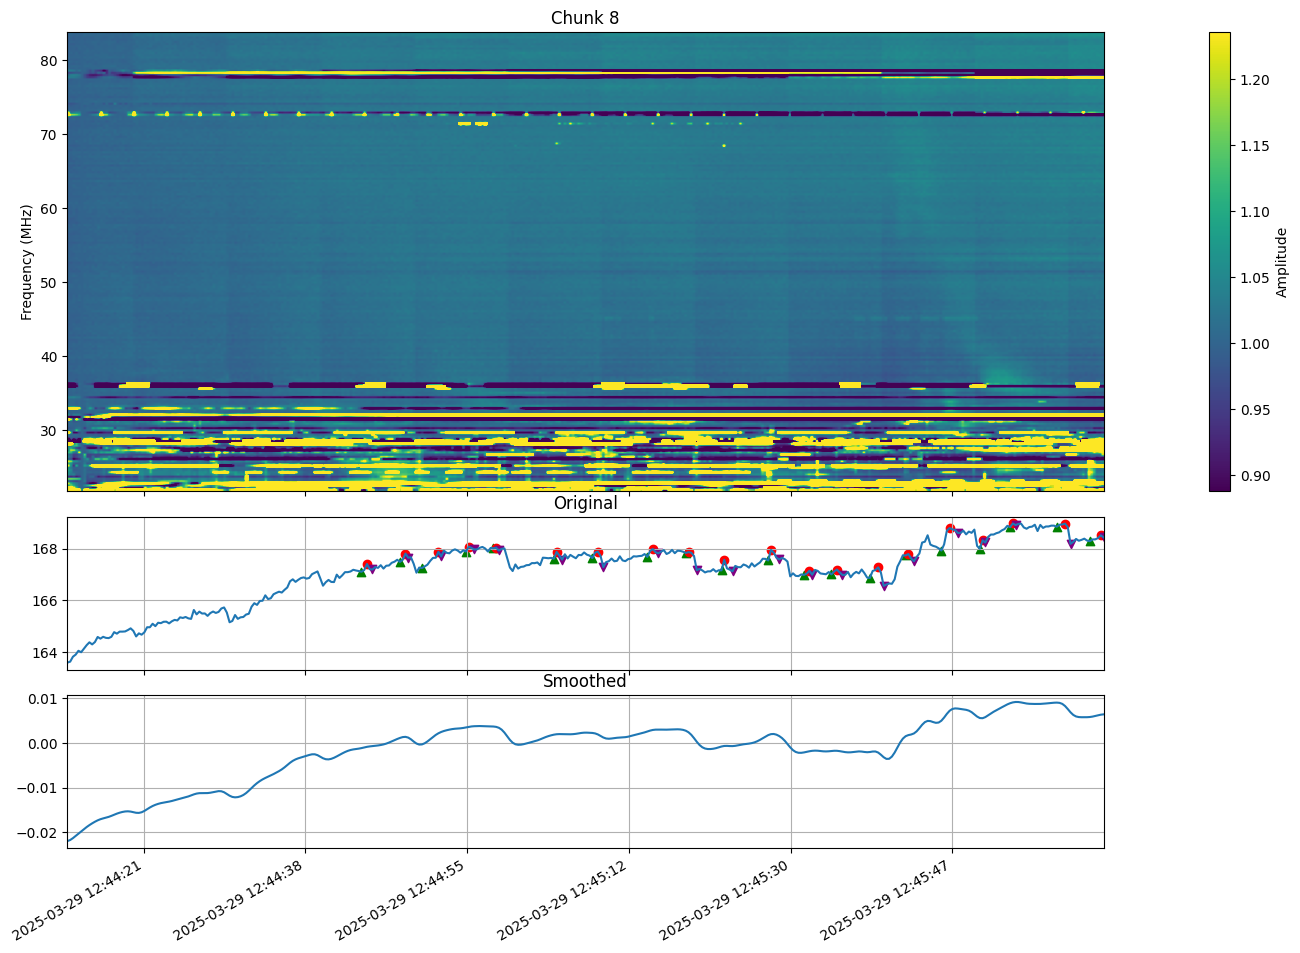

In [23]:
from nenutools.combine_spectra import load_combined_hdf5

data3d, time_jd, time_unix, time_dt, time_mpl, freq = load_combined_hdf5(h5pathCOM)
bursts_o, bursts_s = T3_detection(
    combined_data=data3d,
    combined_time_unix=time_unix,
    combined_time_dt=time_dt,
    combined_time_mpl=time_mpl,
    combined_freq_values=freq,
    output_dir="lab_results", # need to be modified to your own path!
    save_figures=True,  
    save_bursts=True,  
    show=True,  

    chunk_size=500,                    # (int, default=200)  Number of time steps per chunk for burst detection.
    
    pollution_threshold_factor=4,      # (float, default=2)  Factor used to filter out polluted frequency channels 
                                       #                      based on standard deviation.
    
    time_threshold_factor=0.1,           # (float, default=0.3)  Factor used to define start/end thresholds 
                                       #                        for burst detection (30% of peak power).
    
    smoothing_sigma=2,                 # (float, default=1)  Gaussian smoothing sigma for time series 
                                       #                       to enhance burst detection.
    
    overlap=50,                        # (int, default=20)  Number of overlapping time steps between 
                                       #                      adjacent chunks to ensure continuity in burst detection.
    remove_pollution=True,              # (bool, default=True)  If True, apply polluted channel removal.

    show_pollute=True,                  # (bool, default=False) If True, plot the original flux (with polluted channels)
                                       #                      in the dynamic spectrum; otherwise plot the cleaned flux.

    smooth_peak_threshold=0.015         # (float, default=0.05) Threshold in the smoothed signal; peaks below this are ignored.
)

## **Part 3: Analyzing Type III Bursts**

Now that we’ve identified and extracted our burst ROIs, it’s time to dig into the analysis (you already saw it from above, but now more detailed!) and physics:

1. **Assumptions & Inputs**  
   - **Emission mechanism** (“F” vs “H”)  
   - **Density model** (e.g. `saito`, `leblanc98`, `parkerfit`, …)  
   - **Time–frequency window** to include/exclude  **RFI‐polluted channels** 
   - **Fit method** for each channel’s light curve (`FWHM` vs `1/e`)

2. **Drift Rate & Velocity**  
   - Measure **df/dt** in each channel → linear fit → drift rate (MHz s⁻¹)  
   - Convert radio frequency → plasma density → radial distance → beam speed (in c)  

3. **Time‐Profile Analysis**  
   - Characterize **rise**, **peak**, and **decay** times in each channel  
   - Compare different fitting modes (`none` vs `single` (Gaussian fits))  

4. **Parameter Exploration**  
   - How do **density model** or **emission mechanism** choices affect inferred speeds?  
   - What role does **RFI removal** or **noise** play in determining df/dt?  

5. **Science Questions**  
   - Can we correlate radio‐derived beam arrival times with **X-ray flare** signatures?  
   - What do rise vs decay asymmetries reveal about **radio‐wave scattering** in the corona?  
   - Do beams **decelerate** as they propagate? Why it seems that the drift rate decrease over time?  
   - What other **solar radio burst** types (II, IV, etc.) can you spot in the quick‐look data?  




## **3.1:  Batch‐Process Selected Bursts**

Once you’ve detected your bursts and generated the ROI pickles, you can load them back in, define any custom per‐burst frequency ranges, and run the full velocity‐fitting routine on each one:

1. **Load** your saved ROIs with `load_spectra_and_bursts()`  
2. **Optionally** specify per‐burst frequency windows to focus on (e.g. avoid RFI or noisy channels)  
3. **Loop** over each burst, squeeze off any singleton polarization axis, and call `analyze_burst_velocity()`  
   - Choose your **density model**, **emission mechanism**, **fit method**, etc.  
   - Toggle **debug** or **show_density_models** to explore intermediate steps  

In [24]:
# 1) Load the ROIs for the bursts you care about
results = load_spectra_and_bursts(
    results_folder = "lab_results", # Your own path that stored hdf5 files and .plk lists!
    date           = "20250329",
    stokes         = "I",
    burst_type     = "smoothed",
    burst_numbers  = [1, 8, 9, 10]
)

# 2) Define any per-burst frequency ranges you want
freq_ranges = {
    1: (40, 50),
    8: (45, 70),
    9: (40, 70),
    10: (40, 70),
}

# 3) Loop over each burst and run your velocity‐fitting routine
for bn, bd in results.items():
    bd["roi_data"] = bd["roi_data"].squeeze(-1)
    print(f"\n=== Analyzing burst {bn} ===")
    analyze_burst_velocity(
        bd,
        density_model     = "saito",
        emission_mechanism= "F",
        freq_range        = freq_ranges.get(bn),
        fit_method        = "FWHM",
        y_scale           = "none",
        fit_mode          = "none",
        show_density_models=True,
        debug             = False,
        debug_freq_ranges = [(40, 45)]
    )


🔹 Spectra Loaded (HDF5): lab_results/20250329_I_COM.hdf5
   ▶ full spectrum shape: (3528, 208)  (time × freq)
   ▶ full time range  : 2025-03-29 12:28:48.131926 → 2025-03-29 12:46:03.663626
   ▶ full freq range  : 21.73 MHz → 83.75 MHz

✅ Loaded 10 bursts from lab_results/2025_03_29_output_NenuFAR_T3bursts_detection/burst_list_smoothed.pkl

🔹 Burst 1 Slicing:
   • requested time window : 2025-03-29 12:30:36.470787 → 2025-03-29 12:30:56.435676
   • requested freq window : 23.52 → 83.75 MHz
⚠️  No ROI indices for burst 1, skipping.

🔹 Burst 8 Slicing:
   • requested time window : 2025-03-29 12:37:55.404677 → 2025-03-29 12:38:01.863905
   • requested freq window : 22.63 → 83.75 MHz
⚠️  No ROI indices for burst 8, skipping.

🔹 Burst 9 Slicing:
   • requested time window : 2025-03-29 12:38:01.863905 → 2025-03-29 12:38:10.378363
   • requested freq window : 39.67 → 53.13 MHz
⚠️  No ROI indices for burst 9, skipping.

🔹 Burst 10 Slicing:
   • requested time window : 2025-03-29 12:42:54.58438